# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [3]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [4]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [13, 221, 358]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,21217,6208,14982,3095,6707,602
1,5396,7503,10646,91,4167,239
2,759,18664,1660,6114,536,4100


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  

* What kind of establishment (customer) could each of the three samples you've chosen represent?

**Hint:** Examples of establishments include places like markets, cafes, delis, wholesale retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant. You can use the mean values for reference to compare your samples with. The mean values are as follows:

* Fresh: 12000.2977
* Milk: 5796.2
* Grocery: 7951.3
* Frozen : 3071.93
* Detergents_paper: 2881.4
* Delicatessen: 1524.8

Knowing this, how do your samples compare? Does that help in driving your insight into what kind of establishments they might be? 


**Answer:**

* The first one is likley a market since its sells lots of all products except delicatessen, all of the five products are above the mean. 
* The second is likely a minimarket that sells grocery, detergent and paper products.
* The third is likely to be cafe that serves lots of delicatessens and milk based orders. 

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [5]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
grocery = data['Grocery'] 
new_data = data.drop('Grocery', axis = 1)

# TODO: Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
X_train, X_test, y_train, y_test = train_test_split(new_data, grocery, test_size = 0.25, random_state = 21)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train) 
pred_grocery = regressor.predict(X_test)

# TODO: Report the score of the prediction using the testing set
score = r2_score(y_test, pred_grocery)
print("R2 score for this model predicting grocery is: ", score)

R2 score for this model predicting grocery is:  0.771030125756


In [6]:

feature_importance = regressor.feature_importances_
i=0
for key in new_data.columns :
    print(i, key, feature_importance[i])
    i +=1


0 Fresh 0.0244031515593
1 Milk 0.103162483159
2 Frozen 0.0159155190291
3 Detergents_Paper 0.834895854807
4 Delicatessen 0.0216229914459


### Question 2

* Which feature did you attempt to predict? 
* What was the reported prediction score? 
* Is this feature necessary for identifying customers' spending habits?

**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data. If you get a low score for a particular feature, that lends us to beleive that that feature point is hard to predict using the other features, thereby making it an important feature to consider when considering relevance.

**Answer:**

I chose to predict Grocery. The R2 score is 0.771, inidicating that this model shows the change in grocery purchase is moderately associated with the variables in the model. It turned out the the feature most important for predicting grocery purchase is Detergents_Paper with impotance of 0.835. This implies that Grocery is not important by itself in the presence of Detergent-Paper factor. Therefore, we can drop Grocery without too much loss of information. 

We see that Grocery is necessary to identify spending habbits. I am now curious about Delicatessen and Frozen products. I repeat the above process to find their R2 scores are negative. This implies that no other factors can say how customers spend on these products. Therefore, we need to keep them to get better perception on customer spending. 


In [7]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
delicat = data['Delicatessen'] 
new_data = data.drop('Delicatessen', axis = 1)

# TODO: Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
X_train, X_test, y_train, y_test = train_test_split(new_data, delicat, test_size = 0.25, random_state = 21)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train) 
pred_delicat = regressor.predict(X_test)

# TODO: Report the score of the prediction using the testing set
score = r2_score(y_test, pred_delicat)
print("R2 score for this model predicting grocery is: ", score)

R2 score for this model predicting grocery is:  -0.658284033081


### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

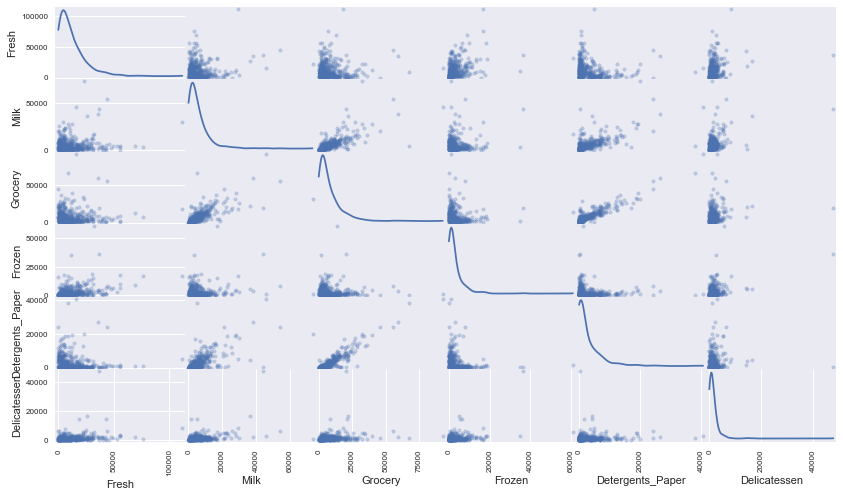

In [8]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well.
* Are there any pairs of features which exhibit some degree of correlation? 
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? 
* How is the data for those features distributed?

**Hint:** Is the data normally distributed? Where do most of the data points lie? You can use [corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to get the feature correlations and then visualize them using a [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html)(the data that would be fed into the heatmap would be the correlation values, for eg: `data.corr()`) to gain further insight.

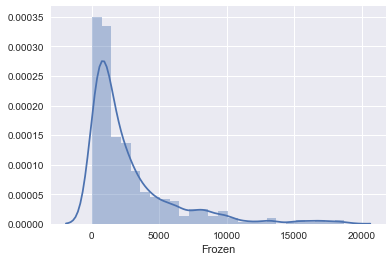

In [9]:
sns.distplot(data['Frozen'][data['Frozen'] < 20000], hist = True)

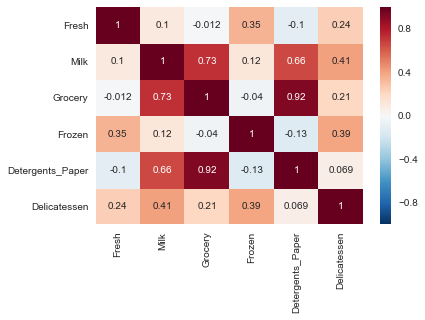

In [10]:
sns.heatmap(data.corr(),annot = True)

**Answer:**

* The scatter matrix shows that each variable in the dataset is highly right skewed with spikes near zero. Long tails of their density curves as well as the pair plots show the presence of extreme points or outliers. However, even when one takes away the extreme points, the concentration of the data near zero show extreme asymmetry which rules out normality of the data. 

* We find from both the scatter plot and the heatmap that the variables that show high to moderate correlation are Grocery, Detergents-Paper and Milk. Not so obvious from the scatter plot but there is a moderately weak correlation between Delicatessen with Milk and Frozen and to a lesser extent with Grocery. Fresh products have no correlation with any of the other variables. The much weaker correlation is between Fresh, Frozen and Delicatessen products. 

* The pair plots and the correlations confirm the relevance of Detergents-Paper and Milk to prdicting Grocery. However, it could not detect the even weak-moderate correlation of Frozen and Milk with Delicatessen.  

* Since all features are cocentrated near zero showing strong asymmetry the data are right skewed with long tails due to some extrem values.  

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

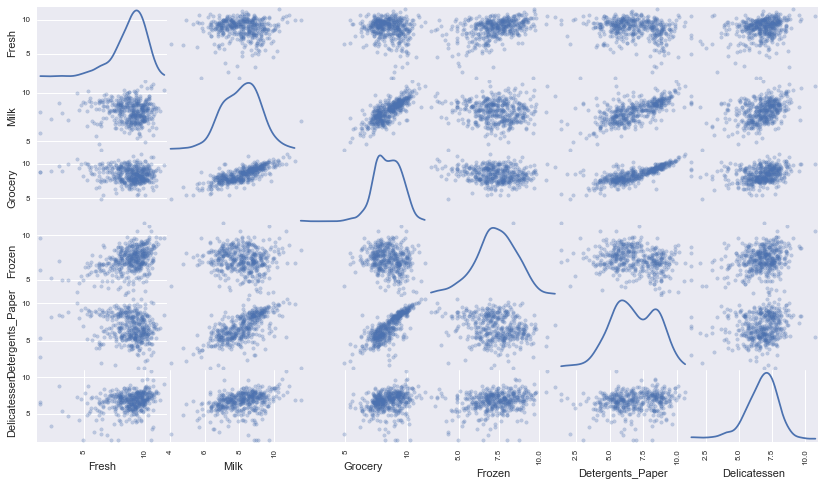

In [11]:
# TODO: Scale the data using the natural logarithm
log_data = data.apply(lambda x: np.log(x+1))

# TODO: Scale the sample data using the natural logarithm
log_samples = samples.apply(lambda x: np.log(x+1))

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [12]:
display(log_data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,8.732813,8.121615,8.442205,7.303128,6.791781,6.671094
std,1.470618,1.080635,1.111523,1.281888,1.709519,1.293960
min,1.386294,4.025352,1.386294,3.258097,1.386294,1.386294
25%,8.048378,7.335633,7.675081,6.611024,5.551989,6.014321
50%,9.048404,8.196435,8.467267,7.331043,6.706242,6.873680
75%,9.737123,8.880619,9.273948,8.176177,8.274596,7.507278
max,11.627610,11.205027,11.437997,11.016496,10.617123,10.777789


### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

### Additional Observation:
Notice that for the original data, the density curve per feature is right skewed with long right tails and high concentration near zero. After log-transformation we see some symmetry, where the right tails are now compressed but we see a left tail in most features. Some are really long as in Fresh, Grocery and Delicatessen. 

In the original case we could consider the right tail as a source of outliers. After transformation, the left tail is more likely to be detected as outliers 

In [14]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.962605,8.733755,9.614672,8.037866,8.811056,6.401917
1,8.593599,8.923191,9.273033,4.521789,8.335192,5.480639
2,6.633318,9.834405,7.415175,8.718500,6.285998,8.318986


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [13]:
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    print('Inter quartile range = ', Q3-Q1)
    print('Q1 = ', Q1, '  Q3 = ', Q3)
    step_L = 1.5*(Q3 - Q1)
    step_R = 1.5*(Q3 - Q1)
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step_L) & (log_data[feature] <= Q3 + step_R))])
    
# OPTIONAL: Select the indices for data points you wish to remove
outliers = [85, 181, 183]

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Inter quartile range =  1.68874462341
Q1 =  8.04837837647   Q3 =  9.73712299987
Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.454347,9.950371,10.732672,3.610918,10.095429,7.261225
66,2.302585,7.336286,8.911665,5.170484,8.151622,3.332205
81,5.393628,9.163354,9.575261,5.648974,8.964312,5.056246
95,1.386294,7.979681,8.740817,6.089045,5.411646,6.565265
96,3.178054,7.869784,9.001962,4.983607,8.262301,5.384495
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294
171,5.303305,10.160569,9.894295,6.480045,9.079548,8.740497
193,5.198497,8.156510,9.918031,6.866933,8.633909,6.502790
218,2.944439,8.923325,9.629445,7.159292,8.475954,8.759826
304,5.087596,8.917445,10.117550,6.426488,9.374498,7.787797


Inter quartile range =  1.54498581252
Q1 =  7.33563334393   Q3 =  8.88061915645
Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.040027,11.205027,10.377078,6.895683,9.907031,6.806829
98,6.222576,4.727388,6.658011,6.797940,4.043051,4.890349
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225
356,10.029547,4.905275,5.389072,8.057694,2.302585,6.308098


Inter quartile range =  1.59886695619
Q1 =  7.67508056293   Q3 =  9.27394751912
Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225


Inter quartile range =  1.56515327882
Q1 =  6.61102411993   Q3 =  8.17617739875
Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.432071,9.663325,9.723763,3.526361,8.847504,6.073045
57,8.597482,9.203718,9.257987,3.663562,8.932345,7.156956
65,4.454347,9.950371,10.732672,3.610918,10.095429,7.261225
145,10.000614,9.034200,10.457171,3.761200,9.440817,8.396381
175,7.759614,8.967759,9.382191,3.970292,8.342125,7.437206
264,6.979145,9.177817,9.645105,4.127134,8.696343,7.143618
325,10.395681,9.728241,9.519808,11.016496,7.149132,8.632306
420,8.402231,8.569216,9.490091,3.258097,8.827468,7.239933
429,9.060447,7.467942,8.183397,3.871201,4.442651,7.824846
439,7.933080,7.437795,7.828436,4.189655,6.169611,3.970292


Inter quartile range =  2.72260683663
Q1 =  5.55198870992   Q3 =  8.27459554655
Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463
161,9.428270,6.293419,5.648974,6.996681,1.386294,7.711549


Inter quartile range =  1.49295648542
Q1 =  6.01432116613   Q3 =  7.50727765156
Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.302585,7.336286,8.911665,5.170484,8.151622,3.332205
109,7.249215,9.724959,10.274603,6.513230,6.729824,1.386294
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294
137,8.035279,8.997271,9.021961,6.495266,6.582025,3.610918
142,10.519673,8.875287,9.018453,8.005033,3.044522,1.386294
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225
183,10.514557,10.690831,9.912001,10.506026,5.480639,10.777789
184,5.793014,6.823286,8.457655,4.317488,5.814131,2.484907
187,7.799343,8.987572,9.192176,8.743532,8.149024,1.386294
203,6.369901,6.530878,7.703910,6.152733,6.861711,2.944439


### Outlier detection for skewed data

When the data is skewed one should be a bit cureful in the method used to identify outliers. The methods suited for the symmetric normal distributions may not be appropriate depending on the degree of skewness. 

The references below suggest the use of the adjusted boxplot fence where the lower and upper limit of the inclusion set are adjusted so that more data in the dense region is included, excluding points in the extreme far right.

When we use the log-transformation of the data, the dense part near zero becomes less dense and create a left tail that is usually cutoff based on Tukey's boxplot definition. 

The MedCouple (MC) is a robust measure of skewness that does not involve the mean or standard deviation, but rather makes use of the median. The median is robust in the sense is that it is not influenced by extreme values. 

MC is defined as follows: For a data set $X = $ \{ $x_1, x_2, \cdots , x_n $\} with median denoted by $med$, MC = median $h(x_i,x_j)$ with $x_i \le med \le x_j$ and where the kernel is defined as : $$ h(x_i,x_j) = \frac{(x_i - med)-(x_j - med) }{x_i - x_j } $$ 

MC takes values between -1 and 1. Positive values indicate right skewness. Negative values indicate left skewness. MC is zero in the case of perfect symmetry. 

Below I code MC. I use it on the original data to identify outliers that need to be removed. I also compute MC for the log-transformed data and to see the degree of skewness that it detects.  



Reference:

[Seo, S. : A Review and Comparison of Methods for Detecting Outliersin Univariate Data Sets](http://d-scholarship.pitt.edu/7948/1/Seo.pdf)

[Hubert, M; Van der Veeken, S.:Outlier detection for skewed data](https://wis.kuleuven.be/stat/robust/papers/2008/outlierdetectionskeweddata-revision.pdf)


In [15]:
# Robust measure of skeweness (different from third moment)
def medcouple(data):
    med = np.median(data)
    list_L = data[data <= med].dropna().values.tolist()
    list_U = data[data > med].dropna().values.tolist()
    h = []
    for x in list_U:
        for y in list_L:
                h.append(((x-med)-(med-y))/(x-y))
    return np.median(h)

# Limits of adjusted boxplot fences to accomodate skewed data distirbution
def adjusted_box(mc, Q1, Q3):
    if mc > 0:    #right skewed
        left  = Q1 -1.5*np.exp(-3.5*mc)*(Q3-Q1)
        right = Q3+ +1.5*np.exp(4*mc)*(Q3-Q1)
    else:   #left_skewed mc<0 or symmetric mc=0
        left  = Q1 -1.5*np.exp(-4*mc)*(Q3-Q1)
        right = Q3+ +1.5*np.exp(3.5*mc)*(Q3-Q1)
    return left, right

print('\nSkewness of original data  \n')    
for feature in log_data.keys():
    print( feature, ' mc = ', medcouple(data[feature]))
    Q1 = np.percentile(data[feature], 25)
    Q3 = np.percentile(data[feature], 75)
    mc = medcouple(data[feature])
    left_limit, right_limit = adjusted_box(mc, Q1, Q3)
    print('Q1 = ', Q1, ',', ' Q3 = ', Q3, ',', 'IQR = ', (Q3-Q1))
    print('limits of adjusted box on original data :', left_limit, ' , ', right_limit )
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(data[~((data[feature] >= left_limit) & (data[feature] <= right_limit))])
    

print('Skewness of log transformed data \n')
for feature in log_data.keys():
    print( feature, ' mc = ', medcouple(log_data[feature]))
    Q1 = np.percentile(log_data[feature], 25)
    Q3 = np.percentile(log_data[feature], 75)
    mc = medcouple(log_data[feature])
    left_limit, right_limit = adjusted_box(mc, Q1, Q3)
    print('limits of adjusted box on log-transformed data :', left_limit, ' , ', right_limit )
    print('limits of adjusted box on log-transformed data, exponentiated:', 
          np.exp(left_limit), ' , ', np.exp(right_limit) )
   


Skewness of original data  

Fresh  mc =  0.28132845996
Q1 =  3127.75 ,  Q3 =  16933.75 , IQR =  13806.0
limits of adjusted box on original data : -4608.51318612  ,  80741.9831479
Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
181,112151,29627,18148,16745,4948,8550


Milk  mc =  0.350247093927
Q1 =  1533.0 ,  Q3 =  7190.25 , IQR =  5657.25
limits of adjusted box on original data : -957.636219757  ,  41636.1987383
Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
47,44466,54259,55571,7782,24171,6465
85,16117,46197,92780,1026,40827,2944
86,22925,73498,32114,987,20070,903
183,36847,43950,20170,36534,239,47943


Grocery  mc =  0.428302918111
Q1 =  2153.0 ,  Q3 =  10655.75 , IQR =  8502.75
limits of adjusted box on original data : -695.505683808  ,  81399.6575985
Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
85,16117,46197,92780,1026,40827,2944


Frozen  mc =  0.492769080154
Q1 =  742.25 ,  Q3 =  3554.25 , IQR =  2812.0
limits of adjusted box on original data : -9.51560546263  ,  33832.7352537
Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
93,11314,3090,2062,35009,71,2698
183,36847,43950,20170,36534,239,47943
325,32717,16784,13626,60869,1272,5609


Detergents_Paper  mc =  0.723375142531
Q1 =  256.75 ,  Q3 =  3922.0 , IQR =  3665.25
limits of adjusted box on original data : -180.412042966  ,  103193.867631
Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen


Delicatessen  mc =  0.282900016896
Q1 =  408.25 ,  Q3 =  1820.25 , IQR =  1412.0
limits of adjusted box on original data : -378.63134399  ,  8387.34986877
Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
23,26373,36423,22019,5154,4337,16523
71,18291,1266,21042,5373,4173,14472
87,43265,5025,8117,6312,1579,14351
181,112151,29627,18148,16745,4948,8550
183,36847,43950,20170,36534,239,47943


Skewness of log transformed data 

Fresh  mc =  -0.21879123398
limits of adjusted box on log-transformed data : 1.97074440662  ,  10.9149617786
limits of adjusted box on log-transformed data, exponentiated: 7.17601637464  ,  54993.0327322
Milk  mc =  -0.089978470616
limits of adjusted box on log-transformed data : 4.01420897388  ,  10.5720167886
limits of adjusted box on log-transformed data, exponentiated: 55.3794714631  ,  39027.3042295
Grocery  mc =  -0.00225177188706
limits of adjusted box on log-transformed data : 5.25508084972  ,  11.6534207521
limits of adjusted box on log-transformed data, exponentiated: 191.536970939  ,  115084.365578
Frozen  mc =  0.0158864060289
limits of adjusted box on log-transformed data : 4.39027085261  ,  10.6779374212
limits of adjusted box on log-transformed data, exponentiated: 80.6622636064  ,  43387.9668966
Detergents_Paper  mc =  0.108584837077
limits of adjusted box on log-transformed data : 2.7592911516  ,  14.5799190276
limits of adjusted box 

### Question 4
* Are there any data points considered outliers for more than one feature based on the definition above? 
* Should these data points be removed from the dataset? 
* If any data points were added to the `outliers` list to be removed, explain why.

** Hint: ** If you have datapoints that are outliers in multiple categories think about why that may be and if they warrant removal. Also note how k-means is affected by outliers and whether or not this plays a factor in your analysis of whether or not to remove them.

**Answer:**

* Based on applying Tukey's definition on the log-transformed data, most of the outliers are due to the spike near zero that we observed in the original data. We notice in the transformed data long lower (left) tails of density curved for most variables. Moreover, observe the presence of extreme variables (away from the dense cloud) towards the left side of the paired scatter plot.   

* Based on the Tukey's boxplot limits as given, there are data points that are considered outliers in more than one variable (65: Fresh & Frozen, 66: Fresh & Delicatessen, 75: Grocery & Detergents-Paper, 128: Fresh & Delicatessen, 154 : Milk & Delicatessen). On the other hand, as I explained for skewed data, its preferable to use the adjusted boxplot on the original data so that to avoid declearing points where the distribution is dense as possible anomalies. There are data points here that are extreme in more than one variable. In particular data points with indeces 181, 183 and 85. These are customers who spend too much on more than one variable.   

* Clustering algorithms such as K-means and Gaussian mixute models use the mean and therefore are sensitive to outliers therefore, it would be important to remove those extreme points. 

* I think its always good to assess analysis with and without extreme data points. I ended up removing customers with indices 181, 183 and 85 as explained earlier they are really extreme (too much spending on more than one variable).   

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

pca_results output: 
               Explained Variance   Fresh    Milk  Grocery  Frozen  \
Dimension 1              0.4466  0.1973 -0.3902  -0.4511  0.1876   
Dimension 2              0.2706 -0.6910 -0.1666  -0.0808 -0.4804   
Dimension 3              0.1160 -0.6684  0.0281  -0.0351  0.3280   
Dimension 4              0.0980 -0.1900  0.0127   0.0640  0.7910   
Dimension 5              0.0456 -0.0028  0.7293   0.3411 -0.0228   
Dimension 6              0.0233 -0.0279  0.5359  -0.8175 -0.0177   

             Detergents_Paper  Delicatessen  
Dimension 1           -0.7429       -0.1352  
Dimension 2           -0.0769       -0.5015  
Dimension 3           -0.2035        0.6342  
Dimension 4            0.2023       -0.5414  
Dimension 5           -0.5629       -0.1852  
Dimension 6            0.2072       -0.0227  


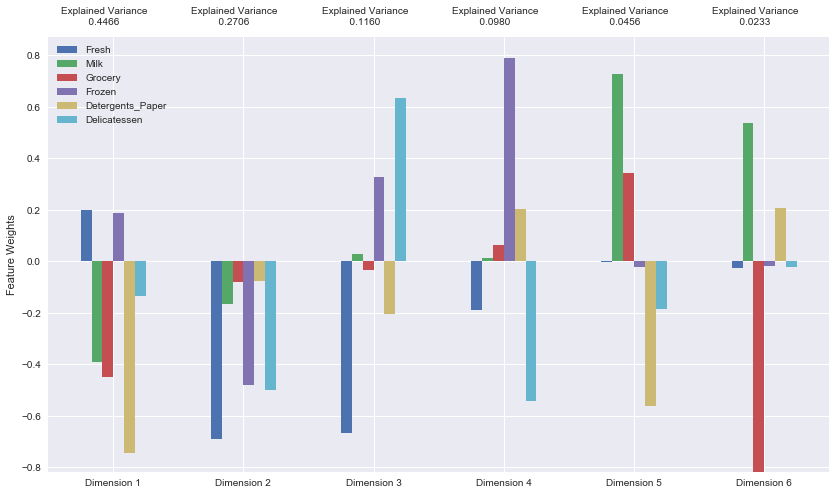

In [16]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components = 6)
pca.fit(good_data)

#print(np.var(pca.transform(good_data),axis =0))
#print('PCA components: \n', pca.components_)
#print('PCA explained variance by each component :', pca.explained_variance_)
#print('Explained variance ratio : \n', pca.explained_variance_ratio_ )
#print('The singular values :', pca.singular_values_)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)
print('pca_results output: \n ', pca_results)

### Question 5

* How much variance in the data is explained* **in total** *by the first and second principal component? 
* How much variance in the data is explained by the first four principal components? 
* Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.

**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the individual feature weights.

In [17]:
print('The first two principal components explain ',
      np.round(pca_results['Explained Variance'][:2].sum()*100,2) , '% of variance in data')
print('The first four principal components explain ',
      np.round(pca_results['Explained Variance'][:4].sum()*100,2) , '% of variance in data')


The first two principal components explain  71.72 % of variance in data
The first four principal components explain  93.12 % of variance in data


**Answer:**

* The first and second principal components explain 71.72 % of variance in data
* The first four principal components explain 93.12 % of variance in data 

* $PC_1$ explains 0.44166 of the variability.  It is influenced the most by the Detergents-Paper produtcts in addition to a slightly less yet in the same direction we have Milk and Grocery. Fresh and Frozen are weaker signals pulling in the opposite direction. In the direction of increase of this PC, we have customers whose spending decrease in spending on Detergent-Paper by 74%, Grocery by 45%, Milk by 39% and Delicatessen by 14%, while increase spending in Fresh products by 20% and Frozen products by 19%. 

* $PC_2$ explains 0.2706 of the variability. It is directed mainly by Fresh, Frozen and Delicatessen products. In the increasing direction of the second dimension customers decrease spending on Fresh products by 69%, Frozen by 48%, Delicatessen by 50% and Milk by 17%.  

* $PC_3$ explains 0.1160 of the variability. It is directed mainly by the stongest two signals of Fresh and Delicatessen products pulling in opposite directions. In the increasing direction of the third dimension, customers increase spending on Delicatessen by 63% and Frozen by 0.33%, while decrease spending on Fresh by 67% and Detergent-Paper by 21%. 

* $PC_4$ explains 0.0980 of the variability. The strongest signal for this PC comes from Frozen products, followed by Delicatessen in pulling in the opposite direction. In the direction of increase of the forth direction, customers increase spending on Frozen products by 79% and Detergent-paper by 20% and decrease in Fresh products by 19% and Delicatessen by 54%. 

* $PC_5$ explains 0.0456 of the variability. is directed by Milk and Grocery in one direction and Detergent-Paper in the opposite direction. In the directioin of increase of the fifth dimension, there is a 73% increase in Milk, 34% increase in Grocery, 56% decrease in Detergent-Paper and 19% decrease in Delicatessen in customer spending.

* $PC_6$ explains 0.0233 of the variability. is directed mainly by Grocery in one direction and Milk in the opposite direction. The direction of increase of the sixth dimension is characterized by  54% increase in Milk and 21% increase in Detergent-Paper with 82% decrease in Grocery spending. 
 

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [18]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-1.8684,-1.4481,-1.1819,0.9849,-0.2528,-0.2541
1,-2.2398,1.6817,-1.8903,-1.1529,0.2913,0.1495
2,-0.2180,-0.2474,3.1044,0.4804,0.8595,1.6479


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [19]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components = 2).fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
reduced_samples = pd.DataFrame(pca_samples, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [20]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-1.8684,-1.4481
1,-2.2398,1.6817
2,-0.2180,-0.2474


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

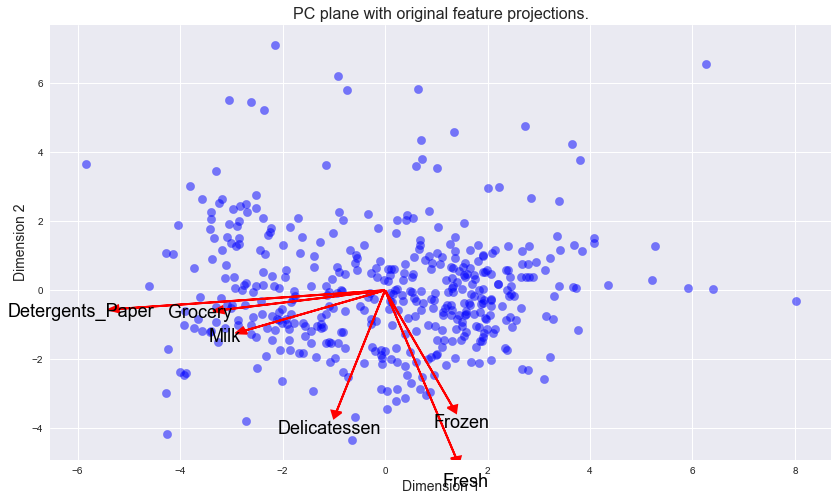

In [21]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6

* What are the advantages to using a K-Means clustering algorithm? 
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

** Hint: ** Think about the differences between hard clustering and soft clustering and which would be appropriate for our dataset.

**Answer:**

* Advantages of K-Means clustering is that its easy to understand and implement. It is a hard clustering algorithm in the sense that each data point belongs to only one cluster. This makes it easy to interpret. It is also efficient when the data is clumped in a ball-shaped region, rather than elongated and curved.   

* Advantages of Gaussian Mixture Model (GMM) is that it allows soft clustering where data points may belong to multiple clusters. The algorithm also allows clusters that are not necessarity ball-shaped, or clusters where one inside another.

* For the data set under consideration, I would consider the K-Means clustering algorithm. Examining the biplot of the first two principal components, we observe the points are somewhat clustered in two rounded regions. 

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [26]:
# TODO: Apply your clustering algorithm of choice to the reduced data 
clusterer = KMeans(n_clusters = 2)
clusterer.fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data) 

# TODO: Find the cluster centers
centers = clusterer.cluster_centers_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(reduced_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds, metric='euclidean')
print(score)
print(centers)

0.423644161733
[[-2.22702461  0.185505  ]
 [ 1.48751644 -0.12390601]]


### Question 7

* Report the silhouette score for several cluster numbers you tried. 
* Of these, which number of clusters has the best silhouette score?

**Answer :**

K-Means: 

|Clusters | Silhouette score |     
|---------|------------------|
|   2     |  0.4236          |
|   3     |  0.3936          |
|   4     |  0.3367          |
|   5     |  0.3541          |
|   6     |  0.3645          |

we observe the best score is when we use two clusters.


### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

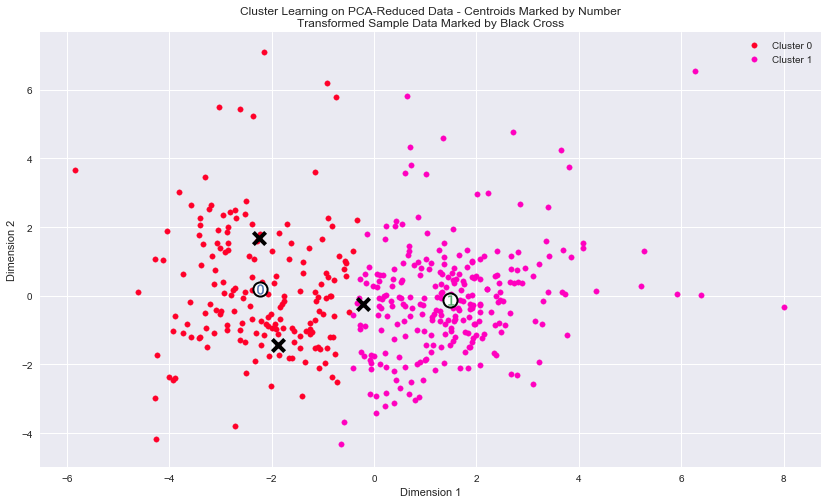

In [27]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [28]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]

true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
#display(true_centers)
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,3472.0,7652.0,12314.0,884.0,4547.0,955.0
Segment 1,8946.0,1891.0,2363.0,2058.0,295.0,675.0


### Question 8

* Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project(specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?

**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`. Think about what each segment represents in terms their values for the feature points chosen. Reference these values with the mean values to get some perspective into what kind of establishment they represent.

**Answer:**

Segments 0 (the cluster on the left) is easy to identify as a market that sells all products but predominantly Milk, Grocery and Detergents-Paper products, where each of these products is above the dataset mean. Maybe these customers are experiencing hight turnover which implies they are busy shops.

Segment 1 is a bit harder to identify. The total purchase per each of the categories is below the correspoding dataset mean. So this is maybe a hotel or a small deli/cafe that is not too busy maybe associated with a hotel.  

### Question 9

* For each sample point, which customer segment from* **Question 8** *best represents it? 
* Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [29]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1


**Answer:**

Looking back at the sample points and considering the clustering above, I find this very reasonable.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

* How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*

**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

The small deli/cafe/hotel (none market) segment (1) does not have a high demand is the segment that I expect to be postive about reduced distrbution schedule. 

The high demand market segment (0) may not like the reduced schedule . 

Given the above expectation we can design a A/B test by applying what is called a randomized blocked experiment. We block the customers into their segment and from each segment we randomly assign customers to a group B who will receive the news of the reduced delivery schedule. That is each segment will have two groups one with the regular delivery and another with the reduced schedule. The blocking reduces possible variability due to the nature of the customer's demand. 

The results would help the distributor to decided to which type of customers the change will be accepted. 

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
* How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?

**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**

I would use a classification model to make a prediction of a label. The classification model will use the product spending on each category as features and the customer segment as a target. 

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

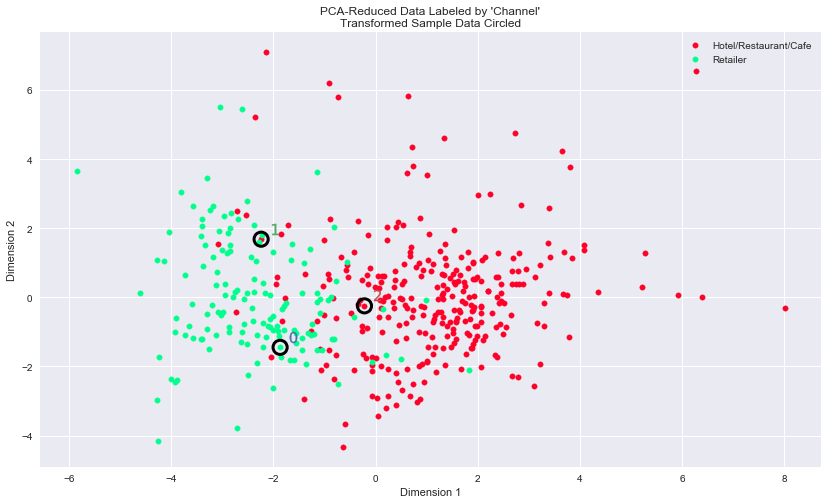

In [30]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

### Question 12

* How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? 
* Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? 
* Would you consider these classifications as consistent with your previous definition of the customer segments?

**Answer:**

* The clustering algorithm did well in defining the clusters and in identifying the customer segment type. The silhouette score validated the correct number of clusters.
* One observes that there is kind of overlap between the two clusters. I wonder whether adding an additional dimension would help with this issue. 
* An I pointed out above, the classification is well aligned with the cutomer segment as labeled by `Channel`. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.